In [64]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import rasterize
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import box
from shapely import Point
import numpy as np
from math import ceil
import netCDF4 as nc
from sklearn.model_selection import RandomizedSearchCV

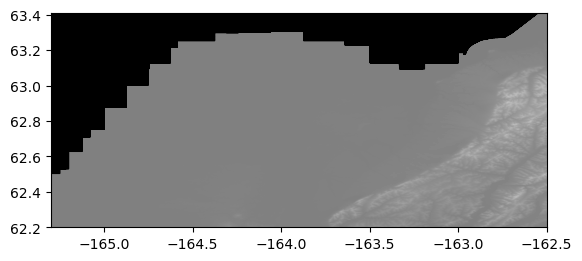

<Axes: >

In [2]:
#import YkDelta Elevation
Elev = rio.open("Data/elevation.tif")
show(Elev,cmap = 'gray',vmin=-1000,vmax=1000)

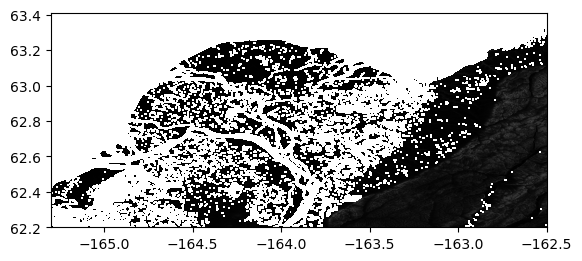

<Axes: >

In [3]:
#import YkDelta Slope
Slope = rio.open("Data/slope.tif")
show(Slope,cmap = 'gray',vmin=0,vmax=90)

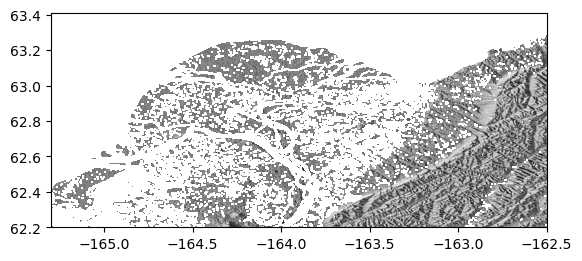

<Axes: >

In [4]:
#import YkDelta Aspect
Aspect = rio.open("Data/aspect.tif")
show(Aspect,cmap = 'gray',vmin=0,vmax=360)

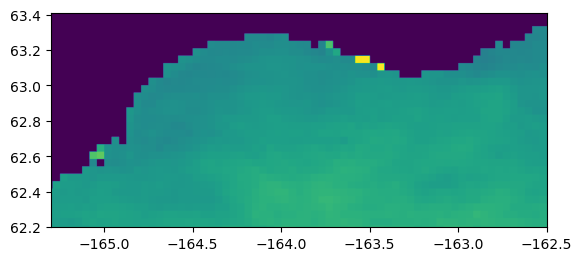

<Axes: >

In [5]:
#import YkDelta Average Max Monthly Temperature years 2000-2021 
max_avg_temp = []
for i in range(2000,2022,1):
    file_name = "Data/avg_maxtemp/avgmaxTemp_" + str(i) + ".tif"
    temp = rio.open(file_name) 
    max_avg_temp.append(temp)
show(temp)

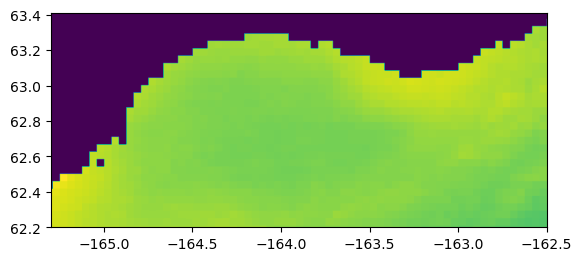

<Axes: >

In [6]:
#import Precipitation years 2000-2021 
precip = []
for i in range(2000,2022,1):
    file_name = "Data/precip/precip_" + str(i) + ".tif"
    pr = rio.open(file_name) 
    precip.append(pr)
show(pr)

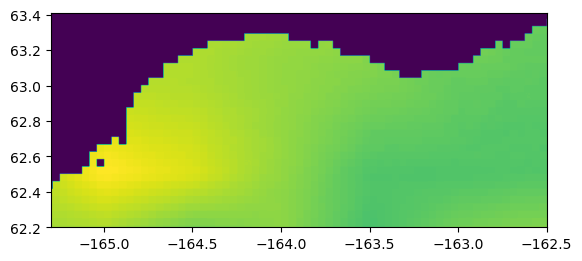

<Axes: >

In [7]:
#import Average Soil Moisture years 2000-2021 
soil = []
for i in range(2000,2022,1):
    file_name = "Data/soil/soil_" + str(i) + ".tif"
    sm = rio.open(file_name) 
    soil.append(sm)
show(sm)

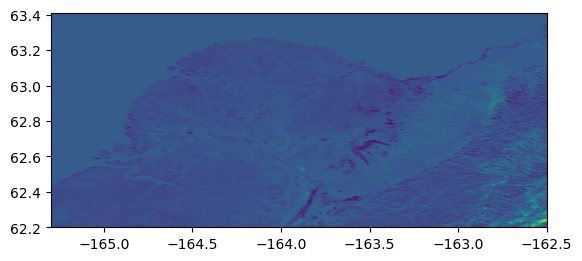

<Axes: >

In [8]:
# import NDVI years 2000-2021 
NDVI = []
for i in range(2000,2022,1):
    file_name = "Data/NDVI/NDVI_" + str(i) + ".tif"
    vi = rio.open(file_name) 
    NDVI.append(vi)
show(vi)

In [9]:
ds = nc.Dataset("Data/annual_indices.nc")
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    creation_date: 2022-10-27T22:42:54Z
    dimensions(sizes): lon(153), lat(68), year(125), model(11), scenario(3)
    variables(dimensions): float64 lon(lon), float64 lat(lat), int64 year(year), <class 'str'> model(model), <class 'str'> scenario(scenario), float32 hsd(model, scenario, year, lat, lon), int32 wndd(model, scenario, year, lat, lon), float64 rx1day(model, scenario, year, lat, lon), float64 rx5day(model, scenario, year, lat, lon), int32 r10mm(model, scenario, year, lat, lon), int32 cwd(model, scenario, year, lat, lon), int32 cdd(model, scenario, year, lat, lon), float32 hd(model, scenario, year, lat, lon), int32 su(model, scenario, year, lat, lon), int32 wsdi(model, scenario, year, lat, lon), float32 cd(model, scenario, year, lat, lon), int32 dw(model, scenario, year, lat, lon), int32 csdi(model, scenario, year, lat, lon)
    groups: 

In [10]:
ds['r10mm']

<class 'netCDF4._netCDF4.Variable'>
int32 r10mm(model, scenario, year, lat, lon)
    _FillValue: -9999
    units: d
unlimited dimensions: 
current shape = (11, 3, 125, 68, 153)
filling on

In [11]:
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    _FillValue: nan
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (153,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    _FillValue: nan
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (68,)
filling on
<class 'netCDF4._netCDF4.Variable'>
int64 year(year)
unlimited dimensions: 
current shape = (125,)
filling on, default _FillValue of -9223372036854775806 used
<class 'netCDF4._netCDF4.Variable'>
vlen model(model)
vlen data type: <class 'str'>
unlimited dimensions: 
current shape = (11,)
<class 'netCDF4._netCDF4.Variable'>
vlen scenario(scenario)
vlen data type: <class 'str'>
unlimited dimensions: 
current shape = (3,)
<class 'netCDF4._netCDF4.Variable'>
float32 hsd(model, scenario, year, lat, lon)
    _FillValue: nan
    units: cm
unlimited dimensions: 
cu

In [60]:
#import wildfire history
points_2020 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2020/AgecnyHistoricFirePerimeters_2020.shp')
points_2010 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2010_2019/AgencyHistoricFirePerimeters_2010_2019.shp')
points_2000 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2000_2009/AgencyHistoricFirePerimeters_2000_2009.shp')
#points_1990 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1990_1999/AgencyHistoricFirePerimeters_1990_1999.shp')
#points_1980 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1980_1989/AgencyHistoricFirePerimeters_1980_1989.shp')
#points_earlier = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1979_Earlier/AgencyHistoricFirePerimeters_1979_Earlier.shp')

In [13]:
#combine all wildfire history
wildfire_points = gpd.GeoDataFrame(pd.concat([points_2010,points_2000],ignore_index = True))
#wildfire_points = gpd.GeoDataFrame(pd.concat([points_2020,points_2010,points_2000,points_1990,points_1980,points_earlier]))
wildfire_points

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
0,None,HART,2010,2010,CDF,CalFire FRAP,20100729,GPS Ground,3.321198,None,00005505,CASKU,None,Wildfire,None,5717,33873,5717,"POLYGON ((-122.33557 41.65648, -122.33557 41.6..."
1,None,HOLLOW,2010,2010,CDF,CalFire FRAP,20100726,GPS Ground,1.371385,None,00005373,CASKU,None,Wildfire,None,5718,33874,5718,"POLYGON ((-122.78650 41.60234, -122.78647 41.6..."
2,None,RY,2010,2010,CDF,CalFire FRAP,20100331,GPS Ground,7.196177,None,00002154,CASKU,None,Wildfire,None,5719,33875,5719,"POLYGON ((-122.47818 41.60885, -122.47818 41.6..."
3,None,WHISKEY,2010,2010,CDF,CalFire FRAP,20100623,GPS Ground,0.228372,None,00004299,CASKU,None,Wildfire,None,5720,33876,5720,"POLYGON ((-122.91199 41.44231, -122.91202 41.4..."
4,None,ANTELOPE,2010,2010,CDF,CalFire FRAP,20101026,GPS Ground,193.618256,None,00008386,CASLU,None,Wildfire,None,5721,33877,5721,"POLYGON ((-120.21049 35.73980, -120.21049 35.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46016,None,Montgomery,2009,2009,BLM,BLM,201802121157,Mixed Methods,289.935970,2009-CACDD-005602,5602,USCACDD,USCACDD,Wildfire,None,{552F6DF6-7918-4667-BAD5-D86373C4E81C},188418,107389,"POLYGON ((-115.37227 33.16523, -115.37225 33.1..."
46017,None,Midway,2009,2009,BLM,BLM,201802121157,Mixed Methods,111.609330,2009-CACDD-005989,5989,USCAPRI,USCACDD,Wildfire,None,{B98CD870-5605-4F53-A1B4-7A87B6D3E2ED},188441,107412,"MULTIPOLYGON (((-115.11094 32.70706, -115.1109..."
46018,None,Lamb,2009,2009,BLM,BLM,201802121157,Mixed Methods,288.135200,2009-CACDD-060763,60763,USCAPRI,USCARRU,Wildfire,None,{6C9222AA-930B-433F-A732-88E0FD05C5E7},188488,107456,"POLYGON ((-116.99752 33.86912, -116.99731 33.8..."
46019,None,Tram,2009,2009,BLM,BLM,201802121157,Mixed Methods,49.937878,2009-CACDD-005399,5399,USCAPRI,USCABDF,Wildfire,None,{D98C3BC8-9468-413E-ABEC-4AD540CCCC50},188503,107470,"POLYGON ((-116.55948 33.85561, -116.55950 33.8..."


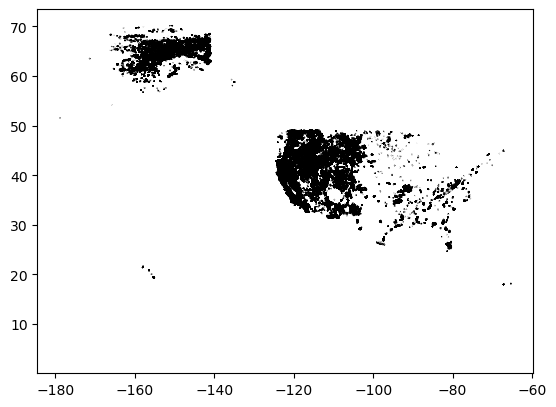

In [14]:
#plt.imshow(test_arr, cmap = 'gray')
f ,ax = plt.subplots()
tiff_extent = [Elev.bounds[0], Elev.bounds[2], Elev.bounds[1], Elev.bounds[3]]
#show(Elev.read(1),extent = tiff_extent, ax = ax )
#ax = plt.gca()
wildfire_points.plot(facecolor = 'w', edgecolor = 'k', ax = ax)#ax = plt.gca())
plt.show()

<Axes: >

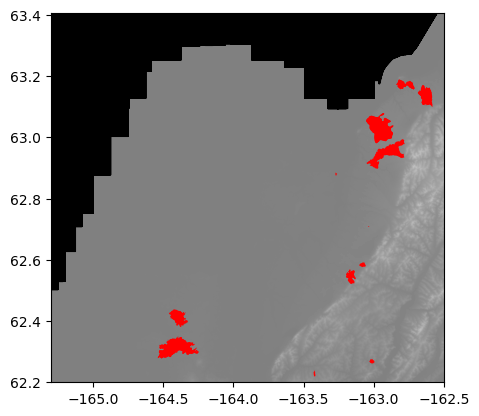

In [15]:
min_x = Elev.bounds[0]
max_x = Elev.bounds[2]
min_y = Elev.bounds[1]
max_y = Elev.bounds[3]

bbox = box(min_x, min_y, max_x, max_y)

wildfire_points_roi = wildfire_points[wildfire_points.geometry.within(bbox)].copy()
#test
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_roi.plot(ax = ax, color = 'r')
#test.plot()
#plt.show()

In [16]:
wildfire_points_roi = wildfire_points_roi.reset_index(drop = True)
wildfire_points_roi

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
0,E62589A2-BEEB-4C62-B7E3-B5AB44788049,Andreafsky,2017,2017,AICC,AFS,201707221425,Image Interpretation,512.227900,2017-AKGAD-000206,000206,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Sentinel 2 imagery.,{AD309E10-F1BA-4474-ABB2-4C786DC7C707},594,77480,"POLYGON ((-163.02204 62.26321, -163.02280 62.2..."
1,2B4F6923-8854-45F4-86B3-501F635FE76F,Allen,2017,2017,AICC,AFS,201707061411,Image Interpretation,2583.490500,2017-AKGAD-000197,000197,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 image.,{4978CB1C-BB87-4786-A06A-A0C8C2AD746F},616,77502,"POLYGON ((-163.18388 62.55729, -163.18302 62.5..."
2,B8494C1F-E7D7-4AD3-BF8F-EF9E364DEA88,Romanoff,2017,2017,AICC,AFS,201707061411,Image Interpretation,3114.854700,2017-AKGAD-000234,000234,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 imagery.,{183C4137-5BEC-480F-A2E6-3ABF1367C1AD},617,77503,"POLYGON ((-162.82381 63.18621, -162.82333 63.1..."
3,14FA22FA-6A8C-4B81-869D-085171A70D8E,Kogok 3,2017,2017,AICC,AFS,201707061411,Image Interpretation,6087.852000,2017-AKGAD-000192,000192,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 imagery.,{D8492CEE-020E-45FA-82ED-D890470517B5},618,77504,"POLYGON ((-162.66321 63.12958, -162.66365 63.1..."
4,5D51BD09-96C4-4973-868C-9DB8D08EA242,Pastolik,2017,2017,AICC,AFS,201706151100,Image Interpretation,11.494000,2017-AKGAD-000213,000213,None,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{52609897-6DB5-4792-BE37-2C3867941CEE},642,77528,"POLYGON ((-163.03354 62.70899, -163.03330 62.7..."
5,6E651734-9DE4-4B1F-B14E-9DCF7DBEE353,Igokluk Slough,2015,2015,AICC,AFS,201507101500,Image Analysis,5645.336000,2015-AKSWS-000459,000459,None,AKSWS,Wildland Final Fire Perimeter,None recorded,{94768385-A84C-4B39-A77A-CE9D45FB982B},1054,77940,"POLYGON ((-164.35417 62.41824, -164.35483 62.4..."
6,2367FF31-EB4C-42DF-9BBB-867AC019B6C7,Anakshek Pass,2015,2015,AICC,AFS,201507101500,Image Analysis,15001.927000,2015-AKSWS-000447,000447,None,AKSWS,Wildland Final Fire Perimeter,None recorded,{20610F2D-9D11-4546-BBE3-47BE0FD9A93F},1055,77941,"POLYGON ((-164.39258 62.34280, -164.39299 62.3..."
7,754CA1B0-59BF-412F-BDB5-B3875D1F1B1D,Apoon,2015,2015,AICC,AFS,201507051400,Digitized,15031.901000,2015-AKGAD-000451,000451,None,AKGAD,Wildland Final Fire Perimeter,Perimeter estimated using VIIRS/MODIS,{4813C9F9-C78B-4CD7-8AC6-68A3C32A10EA},1078,77964,"POLYGON ((-162.96129 62.98727, -162.96285 62.9..."
8,None,17192 Kogok 3,2017,2017,FWS,FWS,None,None,NaN,2017USAKYDRK1PW,K1PW,AKYDR,None,Wildfire,6/6/17\r\nAir Attack B-4 detected a series of ...,48,48,81245,"POLYGON ((-162.66321 63.12958, -162.66365 63.1..."
9,None,17197 Allen,2017,2017,FWS,FWS,None,None,NaN,2017USAKYDRK1QA,K1QA,AKYDR,None,Wildfire,6/7\r\nFire was discovered by the appearance o...,50,50,81247,"POLYGON ((-163.18388 62.55729, -163.18302 62.5..."


In [17]:
#find avaerage ration between Acres and area to determine typtical fire ratio
i = 0
area = 0 
for idx, fire in wildfire_points_roi.iterrows():
    if  not (pd.isna(fire['GIS_ACRES'])):
        #print(fire['GIS_ACRES']/fire.geometry.area)
        area = area + fire['GIS_ACRES']/fire.geometry.area
        i = i + 1
#print('average')
#print(area/i)
ratio = area/i

In [18]:
for idx, fire in wildfire_points_roi.iterrows():
    if pd.isna(fire['GIS_ACRES']):
        #print(fire.geometry.area)
        #print(fire.geometry.area * ratio)
        wildfire_points_roi.at[idx,'GIS_ACRES'] = (fire.geometry.area * ratio)
        
wildfire_points_roi['GIS_ACRES']    

0       512.227900
1      2583.490500
2      3114.854700
3      6087.852000
4        11.494000
5      5645.336000
6     15001.927000
7     15031.901000
8      6193.318804
9      2576.287449
10       11.524938
11     3172.808530
12    15104.300000
13    15105.500000
14     5683.900000
15      249.700940
16      691.827900
17      100.034096
18    12127.565000
Name: GIS_ACRES, dtype: float64

In [19]:
#if desire to split data into classifications of small. medium, large, extreme. Needs more data so going to skip for now
[first_quart, median, third_quart]= wildfire_points_roi['GIS_ACRES'].quantile([.25,.5,.75])
print(first_quart)
print(median)
print(third_quart)

602.0279
3172.808529743859
9160.441902139832


In [20]:
def fire_classify(value):
    if value < first_quart:
        return 1 #small fire
    elif value < median:
        return 2 #medium fire
    elif value < third_quart:
        return 3 #large fire
    else:
        return 4 #extrem fire

In [21]:
#wildfire_points_roi ['Fire_Classification'] = wildfire_points_roi['GIS_ACRES'].apply(fire_classify)
wildfire_points_roi['Fire_Classification'] = 1
wildfire_points_roi

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry,Fire_Classification
0,E62589A2-BEEB-4C62-B7E3-B5AB44788049,Andreafsky,2017,2017,AICC,AFS,201707221425,Image Interpretation,512.227900,2017-AKGAD-000206,000206,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Sentinel 2 imagery.,{AD309E10-F1BA-4474-ABB2-4C786DC7C707},594,77480,"POLYGON ((-163.02204 62.26321, -163.02280 62.2...",1
1,2B4F6923-8854-45F4-86B3-501F635FE76F,Allen,2017,2017,AICC,AFS,201707061411,Image Interpretation,2583.490500,2017-AKGAD-000197,000197,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 image.,{4978CB1C-BB87-4786-A06A-A0C8C2AD746F},616,77502,"POLYGON ((-163.18388 62.55729, -163.18302 62.5...",1
2,B8494C1F-E7D7-4AD3-BF8F-EF9E364DEA88,Romanoff,2017,2017,AICC,AFS,201707061411,Image Interpretation,3114.854700,2017-AKGAD-000234,000234,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 imagery.,{183C4137-5BEC-480F-A2E6-3ABF1367C1AD},617,77503,"POLYGON ((-162.82381 63.18621, -162.82333 63.1...",1
3,14FA22FA-6A8C-4B81-869D-085171A70D8E,Kogok 3,2017,2017,AICC,AFS,201707061411,Image Interpretation,6087.852000,2017-AKGAD-000192,000192,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 imagery.,{D8492CEE-020E-45FA-82ED-D890470517B5},618,77504,"POLYGON ((-162.66321 63.12958, -162.66365 63.1...",1
4,5D51BD09-96C4-4973-868C-9DB8D08EA242,Pastolik,2017,2017,AICC,AFS,201706151100,Image Interpretation,11.494000,2017-AKGAD-000213,000213,None,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{52609897-6DB5-4792-BE37-2C3867941CEE},642,77528,"POLYGON ((-163.03354 62.70899, -163.03330 62.7...",1
5,6E651734-9DE4-4B1F-B14E-9DCF7DBEE353,Igokluk Slough,2015,2015,AICC,AFS,201507101500,Image Analysis,5645.336000,2015-AKSWS-000459,000459,None,AKSWS,Wildland Final Fire Perimeter,None recorded,{94768385-A84C-4B39-A77A-CE9D45FB982B},1054,77940,"POLYGON ((-164.35417 62.41824, -164.35483 62.4...",1
6,2367FF31-EB4C-42DF-9BBB-867AC019B6C7,Anakshek Pass,2015,2015,AICC,AFS,201507101500,Image Analysis,15001.927000,2015-AKSWS-000447,000447,None,AKSWS,Wildland Final Fire Perimeter,None recorded,{20610F2D-9D11-4546-BBE3-47BE0FD9A93F},1055,77941,"POLYGON ((-164.39258 62.34280, -164.39299 62.3...",1
7,754CA1B0-59BF-412F-BDB5-B3875D1F1B1D,Apoon,2015,2015,AICC,AFS,201507051400,Digitized,15031.901000,2015-AKGAD-000451,000451,None,AKGAD,Wildland Final Fire Perimeter,Perimeter estimated using VIIRS/MODIS,{4813C9F9-C78B-4CD7-8AC6-68A3C32A10EA},1078,77964,"POLYGON ((-162.96129 62.98727, -162.96285 62.9...",1
8,None,17192 Kogok 3,2017,2017,FWS,FWS,None,None,6193.318804,2017USAKYDRK1PW,K1PW,AKYDR,None,Wildfire,6/6/17\r\nAir Attack B-4 detected a series of ...,48,48,81245,"POLYGON ((-162.66321 63.12958, -162.66365 63.1...",1
9,None,17197 Allen,2017,2017,FWS,FWS,None,None,2576.287449,2017USAKYDRK1QA,K1QA,AKYDR,None,Wildfire,6/7\r\nFire was discovered by the appearance o...,50,50,81247,"POLYGON ((-163.18388 62.55729, -163.18302 62.5...",1


In [22]:
wildfire_points_roi = wildfire_points_roi[['FIRE_YEAR','Fire_Classification','geometry']]
wildfire_points_roi

,FIRE_YEAR,Fire_Classification,geometry
0,2017,1,"POLYGON ((-163.02204 62.26321, -163.02280 62.2..."
1,2017,1,"POLYGON ((-163.18388 62.55729, -163.18302 62.5..."
2,2017,1,"POLYGON ((-162.82381 63.18621, -162.82333 63.1..."
3,2017,1,"POLYGON ((-162.66321 63.12958, -162.66365 63.1..."
4,2017,1,"POLYGON ((-163.03354 62.70899, -163.03330 62.7..."
5,2015,1,"POLYGON ((-164.35417 62.41824, -164.35483 62.4..."
6,2015,1,"POLYGON ((-164.39258 62.34280, -164.39299 62.3..."
7,2015,1,"POLYGON ((-162.96129 62.98727, -162.96285 62.9..."
8,2017,1,"POLYGON ((-162.66321 63.12958, -162.66365 63.1..."
9,2017,1,"POLYGON ((-163.18388 62.55729, -163.18302 62.5..."


In [23]:
print("Elev Res: " + str(Elev.res))
print("Slope Res: " + str(Slope.res))
print("Aspect Res: " + str(Aspect.res))
print("NDVI Res: " + str(vi.res))
print("Precip Res: " + str(pr.res))
print("Temp Res: " + str(temp.res))
print("NDVI Res: " + str(sm.res))

Elev Res: (0.000628820698883665, 0.000628820698883665)
Slope Res: (0.000628820698883665, 0.000628820698883665)
Aspect Res: (0.000628820698883665, 0.000628820698883665)
NDVI Res: (0.00044915764205976077, 0.00044915764205976077)
Precip Res: (0.0008084837557075694, 0.0008084837557075694)
Temp Res: (0.0008983152841195215, 0.0008983152841195215)
NDVI Res: (0.0008084837557075694, 0.0008084837557075694)


In [24]:
x_spacing = .01
y_spacing = .01
xcoords = [i for i in np.arange(min_x,max_x, x_spacing)]
ycoords = [i for i in np.arange(min_y,max_y, y_spacing)]
pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1,2)
points = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
grid = gpd.GeoSeries(points, crs = wildfire_points_roi.crs)
grid.name = 'geometry'
#gridinside = gpd.sjoin(gpd.GeoDataFrame(grid), wildfire_points_roi[['geometry']], how = 'inner')
wildfire_point_data = gpd.overlay(gpd.GeoDataFrame(grid), wildfire_points_roi, how = 'intersection')

<Axes: >

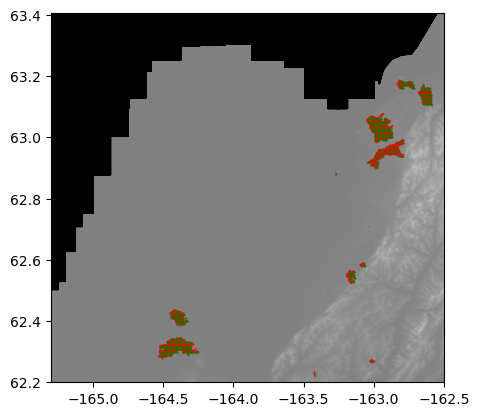

In [25]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_roi.plot(ax = ax, color = 'r')
#grid.plot(ax = ax, color = 'b', markersize = 1)
wildfire_point_data.plot(ax=ax, color = 'g', markersize = .1)
#plt.show()

In [26]:
wildfire_point_data

,FIRE_YEAR,Fire_Classification,geometry
0,2015,1,POINT (-164.52061 62.28980)
1,2015,1,POINT (-164.52061 62.29980)
2,2015,1,POINT (-164.52061 62.30980)
3,2015,1,POINT (-164.52061 62.31980)
4,2015,1,POINT (-164.51061 62.27980)
...,...,...,...
772,2017,1,POINT (-162.60061 63.15980)
773,2017,1,POINT (-162.59061 63.10980)
774,2017,1,POINT (-162.59061 63.11980)
775,2017,1,POINT (-162.59061 63.12980)


In [27]:
Elevation_values = []
Slope_values = []
Aspect_values = []
NDVI_values = []
Soil_values = []
Temp_values = []
Precip_values = []

for index , row in wildfire_point_data.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    year_index = int(row.FIRE_YEAR) - 2000
    px, py = Elev.index(x,y)
    Elevation_values.append(Elev.read(1)[px,py])
    px , py = Slope.index(x,y)
    Slope_values.append(Slope.read(1)[px,py])
    px , py = Aspect.index(x,y)
    Aspect_values.append(Aspect.read(1)[px,py])
    px , py = NDVI[year_index].index(x,y)
    NDVI_values.append(NDVI[year_index].read(1)[px,py])
    px , py = soil[year_index].index(x,y)
    Soil_values.append(soil[year_index].read(1)[px,py])
    px , py = max_avg_temp[year_index].index(x,y)
    Temp_values.append(max_avg_temp[year_index].read(1)[px,py])
    px , py = precip[year_index].index(x,y)
    Precip_values.append(precip[year_index].read(1)[px,py])
    
    
    
    

In [28]:
wildfire_point_data['Elevation'] = Elevation_values
wildfire_point_data['Slope'] = Slope_values
wildfire_point_data['Aspect'] = Aspect_values
wildfire_point_data['NDVI'] = NDVI_values
wildfire_point_data['Soil_Moisture'] = Soil_values
wildfire_point_data['Max_Avg_Temp'] = Temp_values
wildfire_point_data['Precipitation'] = Precip_values

In [29]:
wildfire_point_data

,FIRE_YEAR,Fire_Classification,geometry,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,2015,1,POINT (-164.52061 62.28980),12.258345,0.623544,9.756042,-517,569.250000,42.250000,659.0
1,2015,1,POINT (-164.52061 62.29980),13.987367,0.757594,55.155090,-408,583.416667,41.166667,656.0
2,2015,1,POINT (-164.52061 62.30980),15.065863,0.628637,322.193207,-380,583.416667,41.166667,656.0
3,2015,1,POINT (-164.52061 62.31980),16.269814,0.610275,257.479645,-459,583.416667,41.166667,656.0
4,2015,1,POINT (-164.51061 62.27980),5.847862,1.575962,298.780090,-458,569.250000,42.250000,659.0
...,...,...,...,...,...,...,...,...,...,...
772,2017,1,POINT (-162.60061 63.15980),37.727371,1.080759,54.594166,-94,514.583333,37.166667,445.0
773,2017,1,POINT (-162.59061 63.10980),67.983307,1.934529,63.972759,175,510.000000,38.333333,447.0
774,2017,1,POINT (-162.59061 63.11980),58.977859,1.550795,129.394363,-90,510.000000,38.333333,447.0
775,2017,1,POINT (-162.59061 63.12980),58.491081,0.491172,20.497889,-92,514.583333,37.166667,445.0


<Axes: >

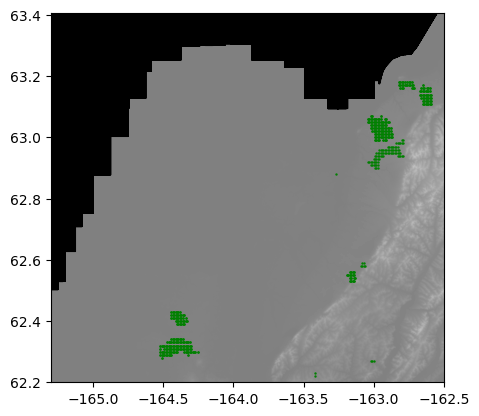

In [30]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
#wildfire_points_roi.plot(ax = ax, color = 'r')
#grid.plot(ax = ax, color = 'b', markersize = 1)
wildfire_point_data.plot(ax=ax, color = 'g', markersize = .5)

For chosing non-fire examples there are a lot if different strategies one can engage.
- completely random:choose randomly between all non-firepoints on the map
- stratified: ensures selected points maintains distribution of dataset
- Spatial: ensure we sample all spatial regions
- Systematic: selecting points at regular intervals

For this example, an equal number of random points for each year will be selected

In [31]:
num_per_year = ceil(len(wildfire_point_data)/21)
num_per_year

37

In [32]:
grid_land = []
def mask_to_land(point):
    px, py = Elev.index(point.x,point.y)
    point_elevation = Elev.read(1)[px-1,py]
    if point_elevation > 0:
        grid_land.append(point)

In [33]:
spacing = .01
xcoords = [i for i in np.arange(min_x,max_x, spacing)]
ycoords = [i for i in np.arange(min_y,max_y, spacing)]
pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1,2)
points = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
grid = gpd.GeoSeries(points, crs = wildfire_points_roi.crs)
grid.name = 'geometry'
grid_gdf = gpd.GeoDataFrame(grid)
"""
grid_land = []
for point in grid_gdf.geometry:
    px, py = Elev.index(point.x,point.y)
    point_elevation = Elev.read(1)[px-1,py]
    
    if point_elevation > 0:
        grid_land.append(point)
"""
grid_gdf.geometry.apply(mask_to_land)
land_gdf = gpd.GeoDataFrame(geometry=grid_land,  crs = wildfire_points_roi.crs)

<Axes: >

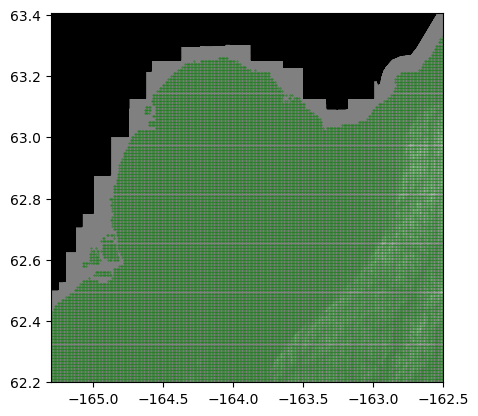

In [34]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
#wildfire_points_roi.plot(ax = ax, color = 'r')
land_gdf.plot(ax=ax, color = 'g', markersize = .1)
#plt.show()

In [35]:
test = gpd.sjoin(land_gdf,wildfire_points_roi,how='left', predicate='within')
filtered_points = test[test.index_right.isna()]

<Axes: >

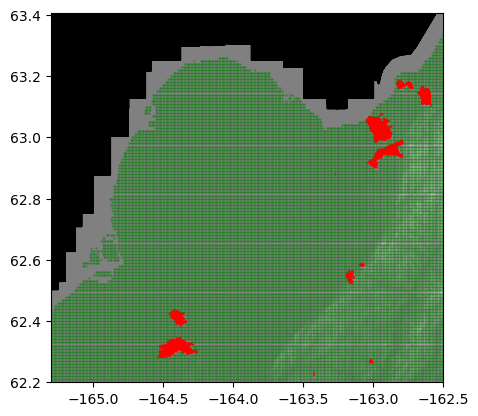

In [36]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_roi.plot(ax = ax, color = 'r')
filtered_points.plot(ax=ax, color = 'g', markersize = .1)
#plt.show()

In [37]:
wildfire_points_roi

,FIRE_YEAR,Fire_Classification,geometry
0,2017,1,"POLYGON ((-163.02204 62.26321, -163.02280 62.2..."
1,2017,1,"POLYGON ((-163.18388 62.55729, -163.18302 62.5..."
2,2017,1,"POLYGON ((-162.82381 63.18621, -162.82333 63.1..."
3,2017,1,"POLYGON ((-162.66321 63.12958, -162.66365 63.1..."
4,2017,1,"POLYGON ((-163.03354 62.70899, -163.03330 62.7..."
5,2015,1,"POLYGON ((-164.35417 62.41824, -164.35483 62.4..."
6,2015,1,"POLYGON ((-164.39258 62.34280, -164.39299 62.3..."
7,2015,1,"POLYGON ((-162.96129 62.98727, -162.96285 62.9..."
8,2017,1,"POLYGON ((-162.66321 63.12958, -162.66365 63.1..."
9,2017,1,"POLYGON ((-163.18388 62.55729, -163.18302 62.5..."


In [38]:
non_fire_points = gpd.GeoDataFrame()
for i in range(2000,2021):
    shapes = wildfire_points_roi[wildfire_points_roi['FIRE_YEAR'] == str(i)]
    test = gpd.sjoin(land_gdf,shapes,how='left', predicate='within')
    filtered_points = test[test.index_right.isna()]
    random_points = filtered_points.sample(n=num_per_year, random_state = 42).geometry
    gdf = gpd.GeoDataFrame(random_points)
    gdf['FIRE_YEAR'] = str(i)
    #non_fire_points = non_fire_points.append(gdf)
    non_fire_points = gpd.GeoDataFrame(pd.concat([non_fire_points,gdf]))
    

In [39]:
non_fire_points['Fire_Classification'] = 0
non_fire_points

,geometry,FIRE_YEAR,Fire_Classification
6876,POINT (-164.26061 62.57980),2000,0
4115,POINT (-164.53061 62.46980),2000,0
16186,POINT (-163.32061 62.51980),2000,0
16124,POINT (-163.33061 62.73980),2000,0
11386,POINT (-163.83061 62.40980),2000,0
...,...,...,...
18784,POINT (-163.02061 62.98980),2020,0
17452,POINT (-163.17061 62.52980),2020,0
10007,POINT (-163.97061 63.11980),2020,0
9595,POINT (-164.01061 63.22980),2020,0


In [40]:
Elevation_values = []
Slope_values = []
Aspect_values = []
NDVI_values = []
Soil_values = []
Temp_values = []
Precip_values = []

for index , row in non_fire_points.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    year_index = int(row.FIRE_YEAR) - 2000
    px, py = Elev.index(x,y)
    Elevation_values.append(Elev.read(1)[px,py])
    px , py = Slope.index(x,y)
    Slope_values.append(Slope.read(1)[px,py])
    px , py = Aspect.index(x,y)
    Aspect_values.append(Aspect.read(1)[px,py])
    px , py = NDVI[year_index].index(x,y)
    NDVI_values.append(NDVI[year_index].read(1)[px,py])
    px , py = soil[year_index].index(x,y)
    Soil_values.append(soil[year_index].read(1)[px,py])
    px , py = max_avg_temp[year_index].index(x,y)
    Temp_values.append(max_avg_temp[year_index].read(1)[px,py])
    px , py = precip[year_index].index(x,y)
    Precip_values.append(precip[year_index].read(1)[px,py])

In [41]:
non_fire_points['Elevation'] = Elevation_values
non_fire_points['Slope'] = Slope_values
non_fire_points['Aspect'] = Aspect_values
non_fire_points['NDVI'] = NDVI_values
non_fire_points['Soil_Moisture'] = Soil_values
non_fire_points['Max_Avg_Temp'] = Temp_values
non_fire_points['Precipitation'] = Precip_values
non_fire_points

,geometry,FIRE_YEAR,Fire_Classification,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
6876,POINT (-164.26061 62.57980),2000,0,5.131996,0.508266,113.813614,-392,684.000000,30.666667,685.0
4115,POINT (-164.53061 62.46980),2000,0,3.910172,0.599422,121.232697,-443,720.000000,28.500000,709.0
16186,POINT (-163.32061 62.51980),2000,0,36.464413,0.784496,109.764580,-209,553.500000,32.416667,658.0
16124,POINT (-163.33061 62.73980),2000,0,10.715101,0.146787,64.801537,-12,568.416667,31.833333,634.0
11386,POINT (-163.83061 62.40980),2000,0,4.000000,0.000000,-0.000000,-707,608.583333,33.916667,684.0
...,...,...,...,...,...,...,...,...,...,...
18784,POINT (-163.02061 62.98980),2020,0,40.206779,1.964868,76.048943,-298,508.750000,31.750000,549.0
17452,POINT (-163.17061 62.52980),2020,0,57.057251,1.935329,282.842590,-191,515.166667,36.000000,587.0
10007,POINT (-163.97061 63.11980),2020,0,3.242527,0.093252,38.973400,-496,562.583333,31.583333,592.0
9595,POINT (-164.01061 63.22980),2020,0,2.597173,0.235224,221.906952,-359,552.416667,29.750000,580.0


In [42]:
total_data = gpd.GeoDataFrame(pd.concat([wildfire_point_data,non_fire_points], ignore_index = True))
total_data

,FIRE_YEAR,Fire_Classification,geometry,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,2015,1,POINT (-164.52061 62.28980),12.258345,0.623544,9.756042,-517,569.250000,42.250000,659.0
1,2015,1,POINT (-164.52061 62.29980),13.987367,0.757594,55.155090,-408,583.416667,41.166667,656.0
2,2015,1,POINT (-164.52061 62.30980),15.065863,0.628637,322.193207,-380,583.416667,41.166667,656.0
3,2015,1,POINT (-164.52061 62.31980),16.269814,0.610275,257.479645,-459,583.416667,41.166667,656.0
4,2015,1,POINT (-164.51061 62.27980),5.847862,1.575962,298.780090,-458,569.250000,42.250000,659.0
...,...,...,...,...,...,...,...,...,...,...
1549,2020,0,POINT (-163.02061 62.98980),40.206779,1.964868,76.048943,-298,508.750000,31.750000,549.0
1550,2020,0,POINT (-163.17061 62.52980),57.057251,1.935329,282.842590,-191,515.166667,36.000000,587.0
1551,2020,0,POINT (-163.97061 63.11980),3.242527,0.093252,38.973400,-496,562.583333,31.583333,592.0
1552,2020,0,POINT (-164.01061 63.22980),2.597173,0.235224,221.906952,-359,552.416667,29.750000,580.0


<Axes: >

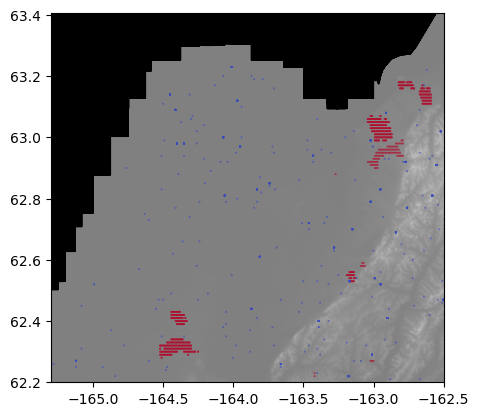

In [43]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
total_data.plot(ax = ax, column = 'Fire_Classification', cmap = 'coolwarm', markersize = .1)

In [44]:
X = total_data.drop(['geometry','FIRE_YEAR','Fire_Classification'], axis = 1)
X

,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,12.258345,0.623544,9.756042,-517,569.250000,42.250000,659.0
1,13.987367,0.757594,55.155090,-408,583.416667,41.166667,656.0
2,15.065863,0.628637,322.193207,-380,583.416667,41.166667,656.0
3,16.269814,0.610275,257.479645,-459,583.416667,41.166667,656.0
4,5.847862,1.575962,298.780090,-458,569.250000,42.250000,659.0
...,...,...,...,...,...,...,...
1549,40.206779,1.964868,76.048943,-298,508.750000,31.750000,549.0
1550,57.057251,1.935329,282.842590,-191,515.166667,36.000000,587.0
1551,3.242527,0.093252,38.973400,-496,562.583333,31.583333,592.0
1552,2.597173,0.235224,221.906952,-359,552.416667,29.750000,580.0


In [45]:
y = total_data['Fire_Classification']
y

0       1
1       1
2       1
3       1
4       1
       ..
1549    0
1550    0
1551    0
1552    0
1553    0
Name: Fire_Classification, Length: 1554, dtype: int64

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=0)
X_train.shape, X_test.shape

((1165, 7), (389, 7))

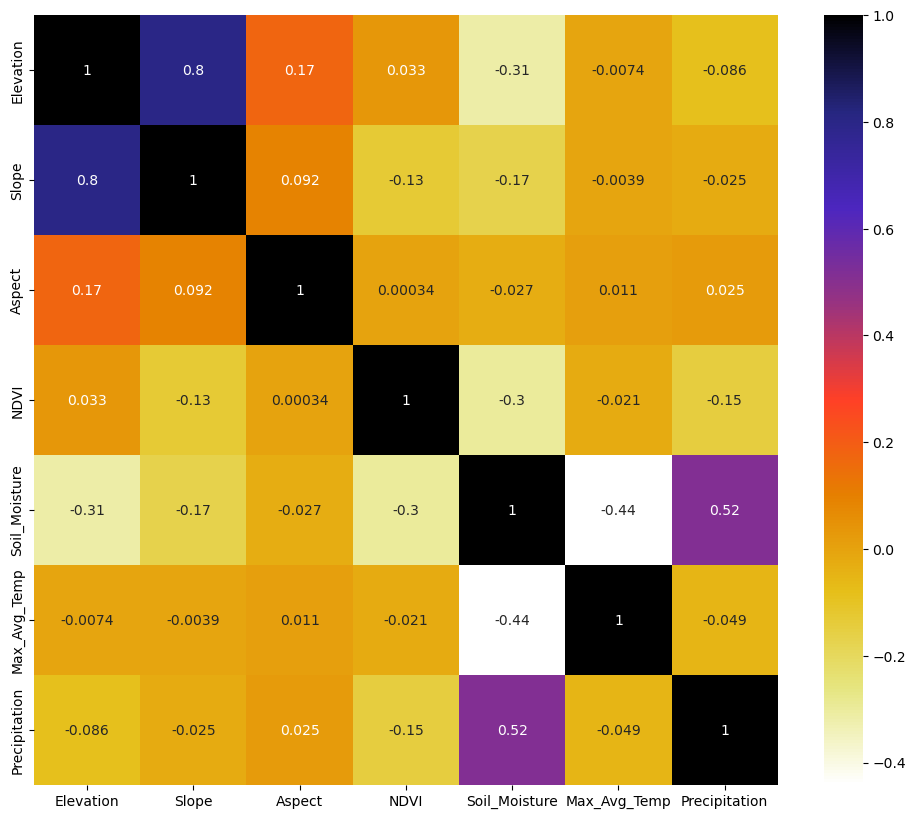

In [47]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [48]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [49]:
print("Training Score: ", xgb.score(X_train,y_train))
print("Test Score: ", xgb.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.9897172236503856


In [50]:
xgb_predic = xgb.predict(X_test)
Score = accuracy_score(y_test, xgb_predic)
Classification_Report = classification_report(y_test, xgb_predic)

print("XGboost Classifier")
print("Accuracy Score value: {:.4f}".format(Score))
print(Classification_Report)


XGboost Classifier
Accuracy Score value: 0.9897
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       0.99      0.99      0.99       200

    accuracy                           0.99       389
   macro avg       0.99      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



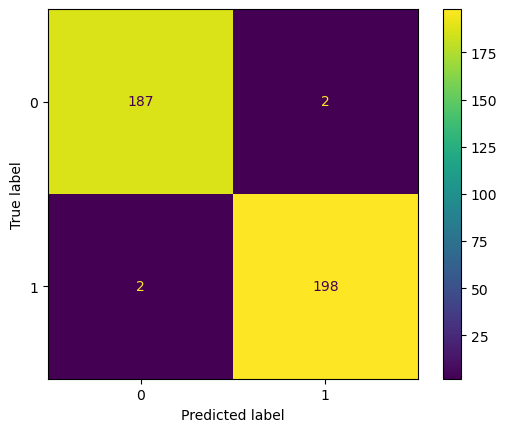

In [51]:
xgb_cm = ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

In [66]:
params={
 "learning_rate"    : (np.linspace(0,10, 100)) ,
 "max_depth"        : (np.linspace(1,50, 25,dtype=int)),
 "min_child_weight" : [1, 3, 5, 7],
 "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
 "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}
Random_xgb = RandomizedSearchCV(xgb, params, cv = 10,n_jobs = -1)
Random_xgb.fit(X_train, y_train).best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=2.121212121212121,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [67]:
Best_xgb = Random_xgb.best_estimator_
Best_xgb.score(X_test,y_test)

0.9125964010282777

In [70]:
Bestxgb_prediction = Best_xgb.predict(X_test)
Bestxgb_prediction

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,

In [71]:
Score = accuracy_score(y_test, Bestxgb_prediction)
Classification_Report = classification_report(y_test,Bestxgb_prediction)
print("FINAL XGB")
print ("Accuracy Score value: {:.4f}".format(Score))
print (Classification_Report)

FINAL XGB
Accuracy Score value: 0.9126
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       189
           1       0.92      0.91      0.91       200

    accuracy                           0.91       389
   macro avg       0.91      0.91      0.91       389
weighted avg       0.91      0.91      0.91       389



In [52]:
xgb.predict_proba(X_test)

array([[9.99886751e-01, 1.13223687e-04],
       [9.98202980e-01, 1.79702556e-03],
       [3.48448753e-04, 9.99651551e-01],
       [1.01727247e-03, 9.98982728e-01],
       [4.20887470e-02, 9.57911253e-01],
       [1.43700838e-03, 9.98562992e-01],
       [9.97685075e-01, 2.31489702e-03],
       [9.99797702e-01, 2.02269788e-04],
       [7.72833824e-04, 9.99227166e-01],
       [9.99925852e-01, 7.41301628e-05],
       [4.30107117e-03, 9.95698929e-01],
       [1.18201971e-03, 9.98817980e-01],
       [1.02061033e-03, 9.98979390e-01],
       [9.99834895e-01, 1.65100850e-04],
       [9.99222577e-01, 7.77424546e-04],
       [9.16365981e-02, 9.08363402e-01],
       [1.98066235e-04, 9.99801934e-01],
       [9.99863386e-01, 1.36633302e-04],
       [8.76724720e-04, 9.99123275e-01],
       [9.98983145e-01, 1.01685175e-03],
       [9.34064388e-04, 9.99065936e-01],
       [9.98989046e-01, 1.01096567e-03],
       [1.40613317e-03, 9.98593867e-01],
       [8.98480415e-04, 9.99101520e-01],
       [8.435249

# Creating a susceptibility Map for the year of 2021

In [53]:
susceptibility_input = land_gdf.copy()

In [54]:
Elevation_values = []
Slope_values = []
Aspect_values = []
NDVI_values = []
Soil_values = []
Temp_values = []
Precip_values = []

for index , row in susceptibility_input.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    year_index = 2020 - 2000
    px, py = Elev.index(x,y)
    Elevation_values.append(Elev.read(1)[px-1,py])
    px , py = Slope.index(x,y)
    Slope_values.append(Slope.read(1)[px-1,py])
    px , py = Aspect.index(x,y)
    Aspect_values.append(Aspect.read(1)[px-1,py])
    px , py = NDVI[year_index].index(x,y)
    NDVI_values.append(NDVI[year_index].read(1)[px-1,py])
    px , py = soil[year_index].index(x,y)
    Soil_values.append(soil[year_index].read(1)[px-1,py])
    px , py = max_avg_temp[year_index].index(x,y)
    Temp_values.append(max_avg_temp[year_index].read(1)[px-1,py])
    px , py = precip[year_index].index(x,y)
    Precip_values.append(precip[year_index].read(1)[px-1,py])

In [55]:
susceptibility_input['Elevation'] = Elevation_values
susceptibility_input['Slope'] = Slope_values
susceptibility_input['Aspect'] = Aspect_values
susceptibility_input['NDVI'] = NDVI_values
susceptibility_input['Soil_Moisture'] = Soil_values
susceptibility_input['Max_Avg_Temp'] = Temp_values
susceptibility_input['Precipitation'] = Precip_values
susceptibility_input

,geometry,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,POINT (-165.30061 62.19980),2.179776,0.600331,80.781494,206,562.666667,33.750000,530.0
1,POINT (-165.30061 62.20980),2.102391,0.795122,143.204788,-391,556.333333,33.833333,525.0
2,POINT (-165.30061 62.21980),1.700000,0.000000,-0.000000,-273,556.333333,33.833333,525.0
3,POINT (-165.30061 62.22980),2.000000,0.000000,-0.000000,1067,556.333333,33.833333,525.0
4,POINT (-165.30061 62.23980),2.254190,1.124480,61.542564,4003,556.333333,33.833333,525.0
...,...,...,...,...,...,...,...,...
24036,POINT (-162.50061 63.28980),1.500000,0.014609,-0.000000,-454,508.500000,28.000000,543.0
24037,POINT (-162.50061 63.29980),2.581420,0.486773,121.314545,-270,506.416667,27.750000,529.0
24038,POINT (-162.50061 63.30980),2.498813,0.752367,296.395569,-227,506.416667,27.750000,529.0
24039,POINT (-162.50061 63.31980),2.572801,0.562308,230.966446,-236,506.416667,27.750000,529.0


In [75]:
susceptibility_input_for_model = susceptibility_input.drop(['geometry'], axis = 1)
susceptibility_output = xgb.predict_proba(susceptibility_input_for_model)
susceptibility_output

array([[9.9987662e-01, 1.2340823e-04],
       [9.9992263e-01, 7.7367127e-05],
       [9.9992913e-01, 7.0861846e-05],
       ...,
       [9.9941522e-01, 5.8477867e-04],
       [9.9951142e-01, 4.8858172e-04],
       [9.9972415e-01, 2.7586764e-04]], dtype=float32)

In [76]:
susceptibility_map = susceptibility_input[['geometry']].copy()
susceptibility_map['fire_risk'] = susceptibility_output[:,1]
susceptibility_map

,geometry,fire_risk
0,POINT (-165.30061 62.19980),0.000123
1,POINT (-165.30061 62.20980),0.000077
2,POINT (-165.30061 62.21980),0.000071
3,POINT (-165.30061 62.22980),0.000123
4,POINT (-165.30061 62.23980),0.000265
...,...,...
24036,POINT (-162.50061 63.28980),0.000079
24037,POINT (-162.50061 63.29980),0.000256
24038,POINT (-162.50061 63.30980),0.000585
24039,POINT (-162.50061 63.31980),0.000489


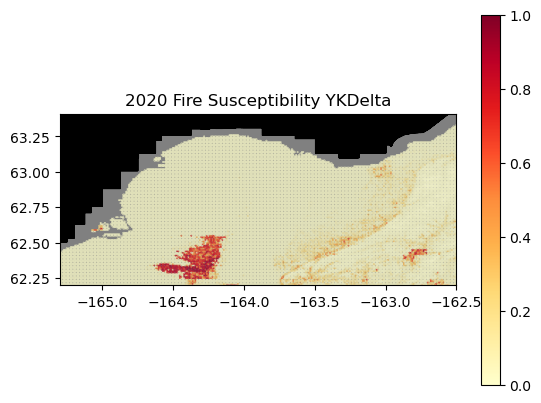

In [77]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
susceptibility_map.plot(ax = ax, column = 'fire_risk', cmap = 'YlOrRd',\
                        markersize = .1, vmin = 0, vmax = 1, legend = True)
plt.title("2020 Fire Susceptibility YKDelta")
plt.gca().set_aspect('equal')

# 

Text(0.5, 1.0, '2020 Burned Area YKDelta')

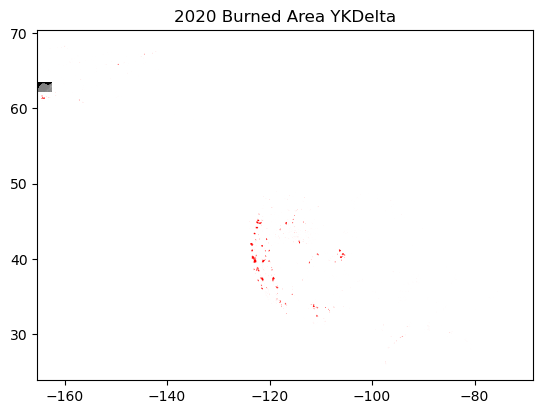

In [78]:
wildfire_points_2020_roi = points_2020[points_2020.geometry.within(bbox)].copy()
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_2020_roi.plot(ax = ax, color = 'r')
plt.title("2020 Burned Area YKDelta")


In [62]:
wildfire_points_2020_roi

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
1206,{1A22F30B-799A-46A0-9249-DB2734E2F4AE},Pastoliak River,2020,2020,AICC,AFS,202006181400,Image Interpretation,59.28849,2020-AKGAD-000280,000280,None,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{A7D7E4E5-19DB-4B48-926F-DB6446D2A0A5},48,76934,"POLYGON ((-162.98149 62.95970, -162.98108 62.9..."
1441,None,20280 Pastoliak Lake,2020,2020,FWS,FWS,None,None,59.60000,2020USAKYDRM6Z5,M6Z5,AKYDR,None,Wildfire,Initial Report On Conditions:\r\nVIIRS seen 6/...,150,150,82836,"POLYGON ((-162.98149 62.95970, -162.98108 62.9..."
